In [1]:
# Plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.available
plt.style.use('seaborn-whitegrid')

%matplotlib notebook

# Neural network
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

# Distributions
import cdae.distributions as dists

# Generative Model

The true generative model $p$ over latents $k, x$ and observed variables $y$ is:
\begin{align}
    k &\sim \mathrm{Categorical}([10, 20], [0.5, 0.5]) \\\
    x &\sim \mathrm{Normal}(0, 1) \\\
    y &\sim \mathrm{Normal}(f(k, x) ,1)
\end{align}
where $f: \mathbb R^2 \to \mathbb R$ is defined as
\begin{align}
    f(k, x) = a(k + x)^2 + b(k + x) + c.
\end{align}


<IPython.core.display.Javascript object>


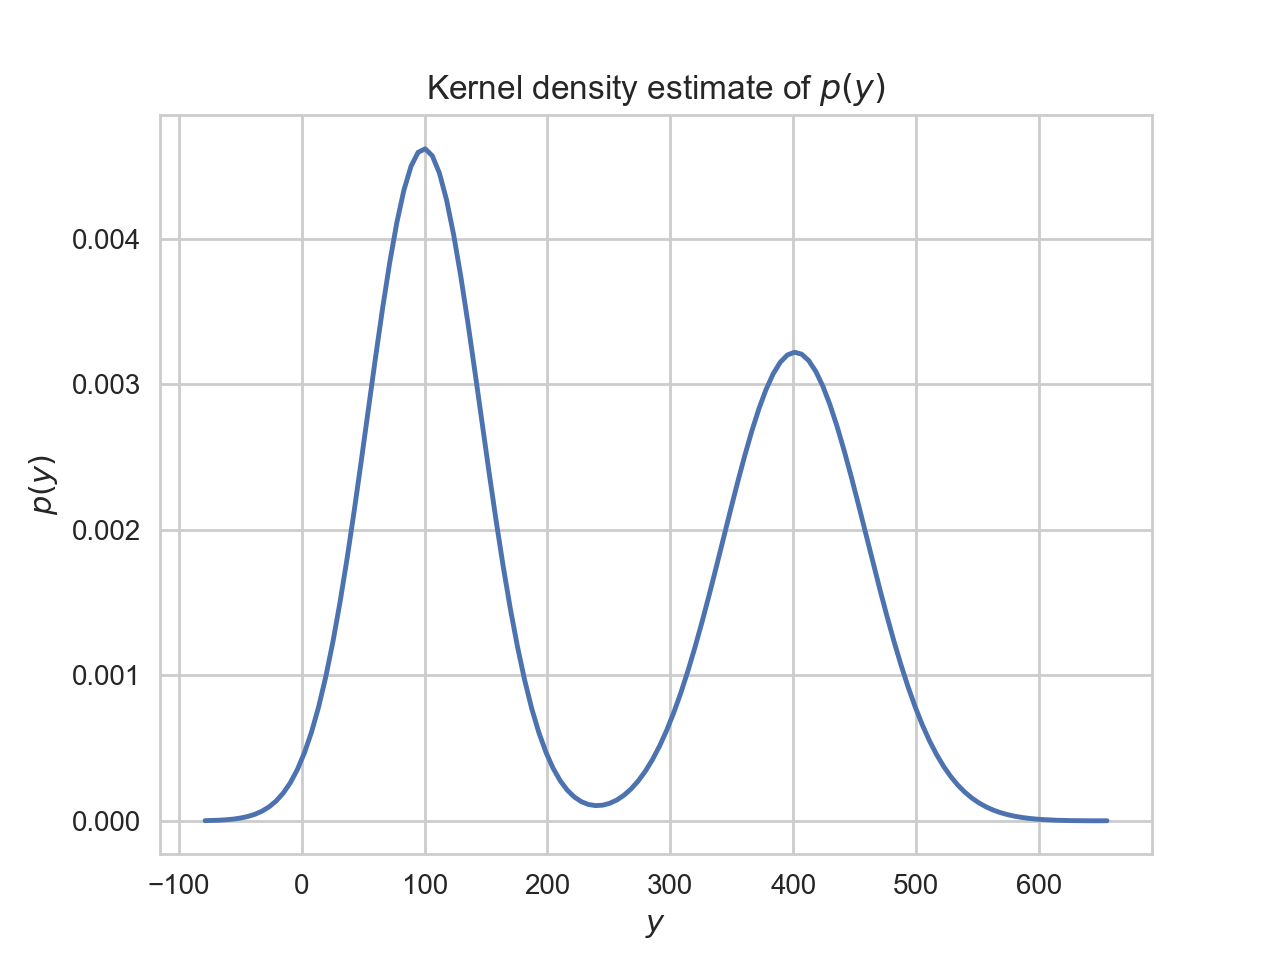

In [2]:
def f(k, x, a, b, c):
    return a * (k + x)**2 + b * (k + x) + c

def generative_model(a, b, c):
    k = np.random.choice([10, 20], p=[0.5, 0.5])
    x = np.random.normal(loc=0, scale=1)
    y = np.random.normal(f(k, x, a, b, c), 1)
    
    return y

(a, b, c) = (1, 0, 0)
num_data = 1000
data = np.array([generative_model(a, b, c) for i in range(num_data)])
fig, ax = plt.subplots()
sns.kdeplot(data, ax=ax)
ax.set_title('Kernel density estimate of $p(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$')

# Generative Network

Assume that we actually don't know the form of $f$ and that we want to learn it, i.e. the true model $p$ from a dataset $(y^{(n)})_{n = 1}^N$.
Let's model the family of functions $f$ under consideration as a neural network parameterized by generative weights $\theta$ such that it maps from $\mathbb R^2$ to $\mathbb R$:

In [3]:
class GenerativeNetwork(nn.Module):
    def __init__(self):
        '''
        Initialize generative network.
        '''
        super(GenerativeNetwork, self).__init__()
        self.lin1 = nn.Linear(2, 16)
        self.lin2 = nn.Linear(16, 1)
        
        init.xavier_uniform(self.lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.lin2.weight)
        
    def f_approx(self, k, x):
        '''
        Returns output of current approximation of f.
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]

        output: Variable [batch_size, 1]
        '''
        
        ret = self.lin1(torch.cat([k, x], dim=1))
        ret = F.relu(ret)
        ret = self.lin2(ret)
        
        return ret

    def forward(self, k, x, y):
        '''
        Returns log p_{\theta}(k, x, y)
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 1]
        '''
        
        batch_size = k.size(0)
        
        logpdf_k = dists.categorical_logpdf(
            k, 
            categories=Variable(torch.FloatTensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)),
            probabilities=Variable(torch.FloatTensor([0.5, 0.5]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1))
        )
        
        logpdf_x = dists.normal_logpdf(x, torch.zeros(x.size()), torch.ones(x.size()))

        mean = self.f_approx(k, x)
        var = torch.ones(mean.size())
        logpdf_y = dists.normal_logpdf(y, mean, var)
        
        return logpdf_k + logpdf_x + logpdf_y
    
    def sample(self, batch_size):
        '''
        Returns sample from the generative model.
        
        input:
            batch_size: int
        
        output:
            k: Tensor [batch_size, 1]
            x: Tensor [batch_size, 1]
            y: Tensor [batch_size, 1]
        '''
        
        k = dists.categorical_sample(
            categories=torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1),
            probabilities=torch.Tensor([0.5, 0.5]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)
        )
        x = dists.normal_sample(
            mean=torch.zeros(batch_size, 1),
            var=torch.ones(batch_size, 1)
        )
        
        mean = self.f_approx(Variable(k, volatile=True), Variable(x, volatile=True)).data
        var = torch.ones(mean.size())
        y = dists.normal_sample(
            mean=mean,
            var=var
        )
        
        return k, x, y
    
    def plot_y_density(self, num_data, ax=None):
        '''
        Returns an Axes object with the kernel density estimate (KDE) of p_{\theta}(y).
        
        input:
            num_data: int. number of data points to make the KDE plot
            ax: (optional) Axes object
            
        output: update ax.
        '''
        
        if ax is None:
            _, ax = plt.subplots()

        _, _, data = self.sample(num_data)
        data = data.view(-1).numpy()

        sns.kdeplot(data, ax=ax)
        ax.set_title('Kernel density estimate of $p_{\\theta}(y)$')
        ax.set_xlabel('$y$')
        ax.set_ylabel('$p_{\\theta}(y)$')

<IPython.core.display.Javascript object>


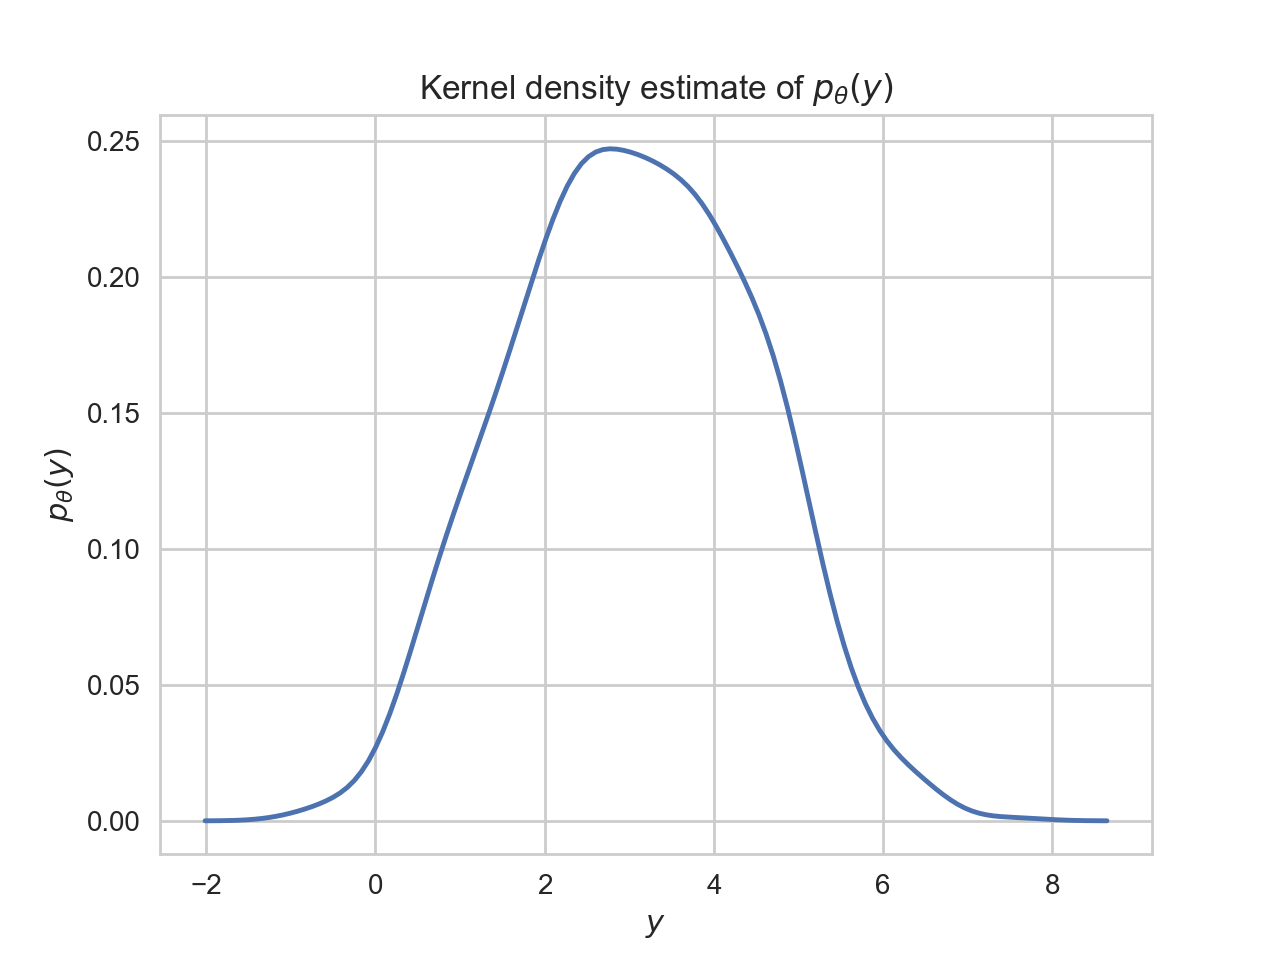

In [4]:
generative_network = GenerativeNetwork()
num_data = 1000
generative_network.plot_y_density(num_data)

# Inference Network

We seek to learn an inference network $q_{\phi}(k, x \lvert y)$ parameterized by $\phi$ which, given $y$ maps to the parameters of the distribution over $(k, x)$, ideally close to the posterior under the true model, $p(k, x \lvert y)$.

Let
\begin{align}
    q_{\phi}(k, x \lvert y) &= q_{\phi}(k \lvert y) q_{\phi}(x \lvert k, y) \\\
    q_{\phi}(k \lvert y) &= \mathrm{Categorical}([10, 20], [\phi_1, \phi_2]) \\\
    q_{\phi}(x \lvert k, y) &= \mathrm{Normal}(\phi_3, \phi_4)
\end{align}
where $\phi = [\phi_1, \dotsc, \phi_4]$ is the output of the inference network.

In [5]:
class InferenceNetwork(nn.Module):
    def __init__(self):
        '''
        Initialize inference network.
        '''
        
        super(InferenceNetwork, self).__init__()
        self.k_lin1 = nn.Linear(1, 16)
        self.k_lin2 = nn.Linear(16, 2)
        
        self.x_mean_lin1 = nn.Linear(2, 16)
        self.x_mean_lin2 = nn.Linear(16, 1)
        
        self.x_var_lin1 = nn.Linear(2, 16)
        self.x_var_lin2 = nn.Linear(16, 1)

        init.xavier_uniform(self.k_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.k_lin2.weight)
        init.xavier_uniform(self.x_mean_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.x_mean_lin2.weight)
        init.xavier_uniform(self.x_var_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.x_var_lin2.weight)
        
    def get_q_k_params(self, y):
        '''
        Returns parameters \phi_1, \phi_2.
        
        input:
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 2]
        '''
        
        ret = self.k_lin1(y)
        ret = F.relu(ret)
        ret = self.k_lin2(ret)
        ret = F.softmax(ret)
        
        return ret
    
    def get_q_x_params(self, k, y):
        '''
        Returns parameters \phi_3, \phi_4.
        
        input:
            k: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output:
            mean: Variable [batch_size, 1]
            var: Variable [batch_size, 1]
        '''
        
        mean = self.x_mean_lin1(torch.cat([k, y], dim=1))
        mean = F.relu(mean)
        mean = self.x_mean_lin2(mean)
        
        var = self.x_var_lin1(torch.cat([k, y], dim=1))
        var = F.relu(var)
        var = self.x_var_lin2(var)
        
        return mean, var
        
    def forward(self, k, x, y):
        '''
        Returns log q_{\phi}(k, x | y)
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 1]
        '''
        batch_size, _ = k.size()
        
        probabilities = self.get_q_k_params(y)
        logpdf_k = dists.categorical_logpdf(
            k,
            categories=Variable(torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)),
            probabilities=torch.t(probabilities).unsqueeze(-1)
        )
        
        mean, var = self.get_q_x_params(k, y)
        logpdf_x = dists.normal_logpdf(
            x,
            mean=mean,
            var=var
        )
        
        return logpdf_k + logpdf_x
    
    def sample(self, y):
        '''
        Returns samples from q_{\phi}(k, x | y)
        
        input:
            y: Tensor [batch_size, 1]

        output:
            k: Tensor [batch_size, 1]
            x: Tensor [batch_size, 1]
        '''
        
        batch_size = y.size(0)
        
        probabilities = self.get_q_k_params(Variable(y, volatile=True)).data
        k = dists.categorical_sample(
            categories=torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1),
            probabilities=torch.t(probabilities).unsqueeze(-1)
        )
        
        mean, var = self.get_q_x_params(Variable(k, volatile=True), Variable(y, volatile=True))
        x = dists.normal_sample(
            mean=mean.data,
            var=var.data
        )
        
        return k, x

average_q_logpdf
-3.57761549949646
y
365.26529259823513


<IPython.core.display.Javascript object>


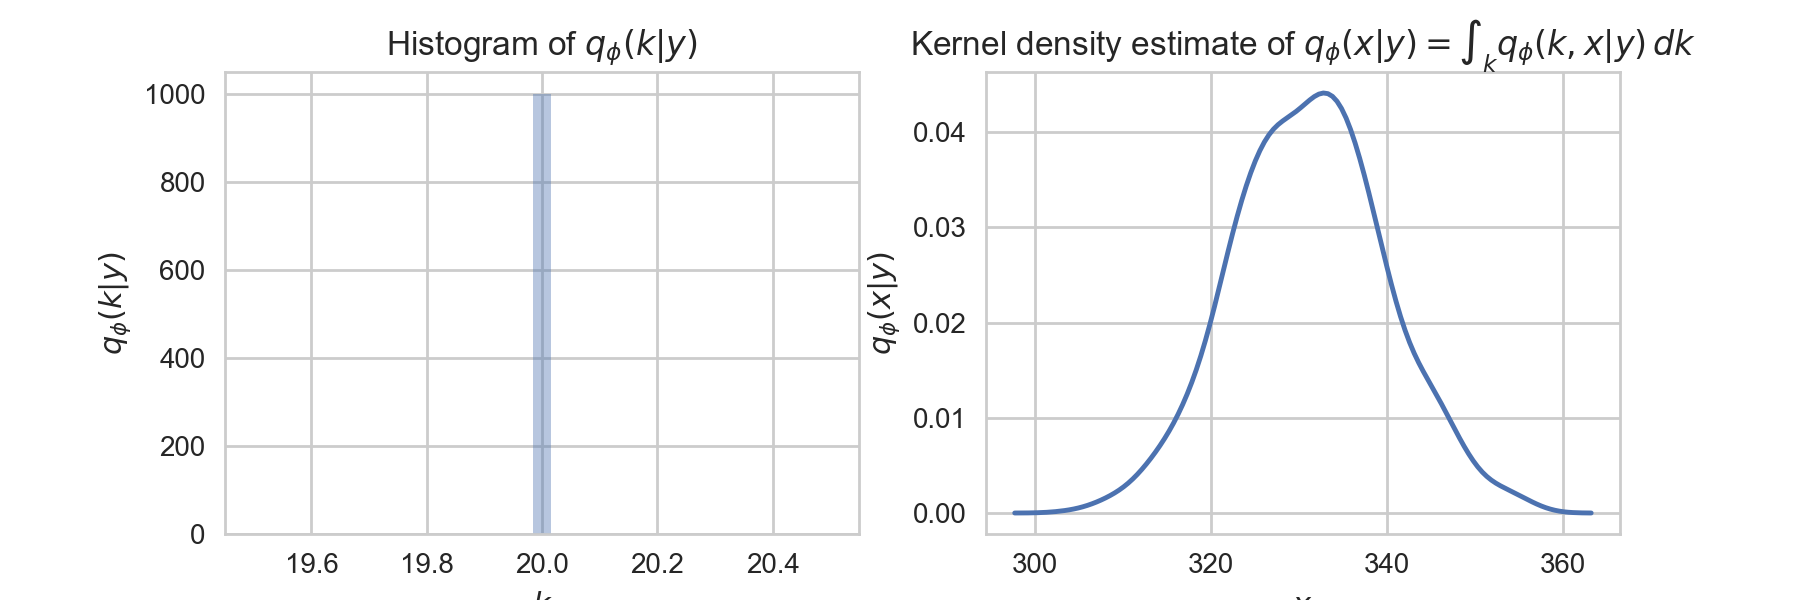

In [6]:
inference_network = InferenceNetwork()
y_single = generative_model(a, b, c)
y = torch.Tensor([[y_single]]).expand(1000, 1)
k, x = inference_network.sample(y)
average_q_logpdf = torch.mean(
    inference_network.forward(
        Variable(k, volatile=True),
        Variable(x, volatile=True), 
        Variable(y, volatile=True)
    )
)
print('average_q_logpdf')
print(average_q_logpdf.data[0])

print('y')
print(y_single)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(9, 3)

sns.distplot(k.view(-1).numpy(), ax=ax[0], kde=False)
ax[0].set_title('Histogram of $q_{\phi}(k | y)$')
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$q_{\phi}(k | y)$')

sns.kdeplot(x.view(-1).numpy(), ax=ax[1])
ax[1].set_title('Kernel density estimate of $q_{\phi}(x | y)  = \int_k q_{\phi}(k, x | y) \,dk$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q_{\phi}(x | y)$')